In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, cos, sin
from scipy.spatial.distance import cdist

We will try to solve the concentrical circles datasets (that breaks the Mixture of Gaussians -- seen by Alberto and Susana) with the different kernel approaches seen in pill 16. 

In [2]:
cov = np.array([[0.1, 0], [0, 0.1]])

def point(h, k, r):
    theta = np.random.random() * 2 * pi
    mean = h + cos(theta) * r, k + sin(theta) * r
    p = np.random.multivariate_normal(mean, cov, 1)
    return p

We slightly modify this code to make the variable $y$ to be 1's and -1's

(200, 2)


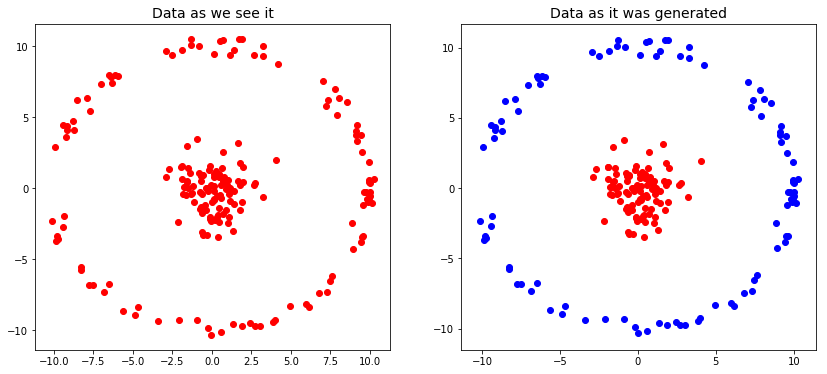

In [204]:
#Create some data
MAXN=100
X = np.array([point(0,0,10)[0] for _ in range(MAXN)])
X = np.concatenate([X, np.random.multivariate_normal([0,0], np.array([[2,0], [0,2]]), MAXN)])
print(X.shape)

#Just for visualization purposes
y = np.concatenate([-1*np.ones((MAXN,1)),np.ones((MAXN,1))])
#y = np.concatenate([np.ones((MAXN,1))])

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==-1).ravel(),0],X[(y==-1).ravel(),1],color='b')
plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))

## Kernel regularized least squares (Gaussian)

In [205]:
def gaussian_kernel(xa,xb,gamma):
    d = cdist(xa,xb,metric='euclidean')
    return np.exp(-d*gamma)

In [209]:
gamma = 2
K = gaussian_kernel(X,X,gamma)
lamb = 1
alpha = np.dot(np.linalg.inv(K+lamb*np.eye(K.shape[0])),y)
print(K.shape, X.shape)

(200, 200) (200, 2)


This color vector is defined because using directly $y$ produces and error.

In [210]:
col = np.zeros(200)
for i in range(0,200):
    col[i]= y[i]
col.shape

(200,)

(40000, 200)


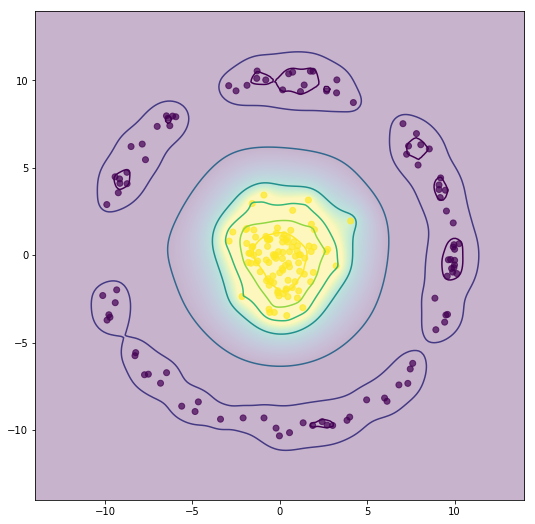

In [211]:
xx,yy = np.meshgrid(np.linspace(-14,14,200),np.linspace(-14,14,200))
viz=np.c_[xx.ravel(),yy.ravel()]


z = np.dot(gaussian_kernel(viz,X,1.),alpha)
print(gaussian_kernel(viz,X,1.).shape)

plt.scatter(X[:, 0], X[:, 1], c=col,  alpha=0.7)
plt.gca().set_xlim([-14.,14.])
plt.gca().set_ylim([-14.,14.])
plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-14,14,-14,14),alpha=0.3, vmin=0, vmax=1)
plt.contour(xx,yy,z.reshape((200,200)))

plt.gcf().set_size_inches((9,9))



## Online Kernel: Perceptrons


In [212]:
def train_perceptron(X,y,gamma,n_iters):
    alpha = np.random.rand(X.shape[0],1)
    for i in range(n_iters):
        idx = np.random.randint(X.shape[0])
        xi,yi = X[idx,:],y[idx]
        if yi*np.dot(gaussian_kernel(xi[np.newaxis,:],X,gamma),alpha)<0:
            alpha[idx] = alpha[idx]+yi
    return alpha

def test_perceptron(xtest,X,alpha,gamma):
    return np.dot(gaussian_kernel(xtest,X,gamma),alpha)

In [217]:
gamma = 1.

alpha = train_perceptron(X,y,gamma,10000)

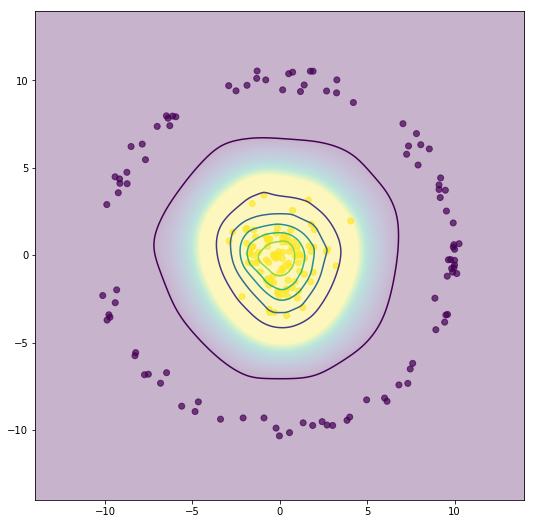

In [218]:
xx,yy = np.meshgrid(np.linspace(-14,14,200),np.linspace(-14,14,200))
viz=np.c_[xx.ravel(),yy.ravel()]

z = test_perceptron(viz,X,alpha,gamma)

plt.scatter(X[:, 0], X[:, 1], c=col,   alpha=0.7)
plt.gca().set_xlim([-14.,14.])
plt.gca().set_ylim([-14.,14.])
plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-14,14,-14,14),alpha=0.3, vmin=0, vmax=1)
plt.contour(xx,yy,z.reshape((200,200)))

plt.gcf().set_size_inches((9,9))

## The online kernel SVM


In [257]:
def train_svm(X,y,gamma,C,eta,n_iters):
    alpha = np.zeros((X.shape[0],1))
    for i in range(n_iters):
        idx = np.random.randint(X.shape[0])
        xi,yi = X[idx,:],y[idx]
        if yi*np.dot(gaussian_kernel(xi[np.newaxis,:],X,gamma),alpha)<=1.:
            g = 2*alpha - C*yi*gaussian_kernel(xi[np.newaxis,:],X,gamma).T
        else:
            g = 2*alpha 
        alpha = alpha - eta*g
    return alpha

def train_svm_stream(xi,yi,sv,gamma,alpha,C,eta,n_iters):   
    if yi*np.dot(gaussian_kernel(xi[np.newaxis,:],sv,gamma),alpha)<=1.:
        g = 2*alpha - C*yi*gaussian_kernel(xi[np.newaxis,:],sv,gamma).T
        alpha = alpha - eta*g    
        sv.append((xi,yi))
        alpha.append(yi)
    else:
        g = 2*alpha 
        alpha = alpha - eta*g
    return alpha,sv


def test_svm(xtest,X,alpha,gamma):
    return np.dot(gaussian_kernel(xtest,X,gamma),alpha)

In [270]:
gamma = 10
C = 1
eta = 0.01

alpha = train_svm(X,y,gamma,C,eta,10000)

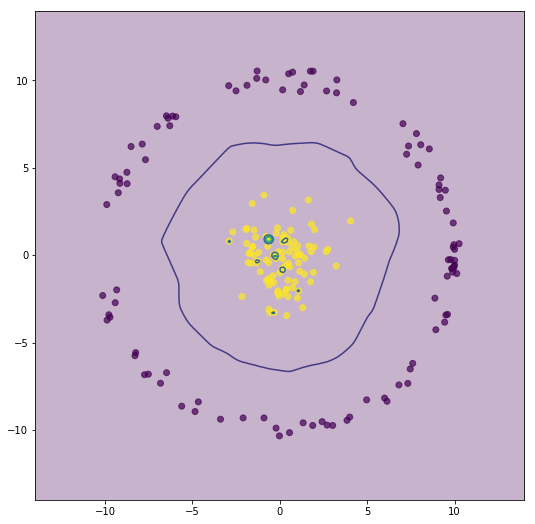

In [271]:
xx,yy = np.meshgrid(np.linspace(-14,14,200),np.linspace(-14,14,200))
viz=np.c_[xx.ravel(),yy.ravel()]

z = test_svm(viz,X,alpha,gamma)

plt.scatter(X[:, 0], X[:, 1], c=col,   alpha=0.7)
plt.gca().set_xlim([-14.,14.])
plt.gca().set_ylim([-14.,14.])
plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-14,14,-14,14),alpha=0.3, vmin=0, vmax=1)
plt.contour(xx,yy,z.reshape((200,200)))

plt.gcf().set_size_inches((9,9))

## The real online SVM


In [273]:
def train_svm(X,y,gamma,C,eta,n_iters):
    mom = 0.
    alpha = np.zeros((X.shape[0],1))
    K = gaussian_kernel(X,X,gamma)
    for i in range(n_iters):
        idx = np.random.randint(X.shape[0])
        xi,yi = X[idx,:],y[idx]
        if yi*np.dot(gaussian_kernel(xi[np.newaxis,:],X,gamma),alpha)<=1.:
            g = 2*np.dot(K,alpha) - C*yi*gaussian_kernel(xi[np.newaxis,:],X,gamma).T
        else:
            g = 2*np.dot(K,alpha) 
            
        mom = 0.9*mom - g
        alpha = alpha + eta*mom
    return alpha

def test_svm(xtest,X,alpha,gamma):
    return np.dot(gaussian_kernel(xtest,X,gamma),alpha)

In [276]:
gamma = 1e2
C = 1e-1
eta = 0.001

alpha = train_svm(X,y,gamma,C,eta,10000)

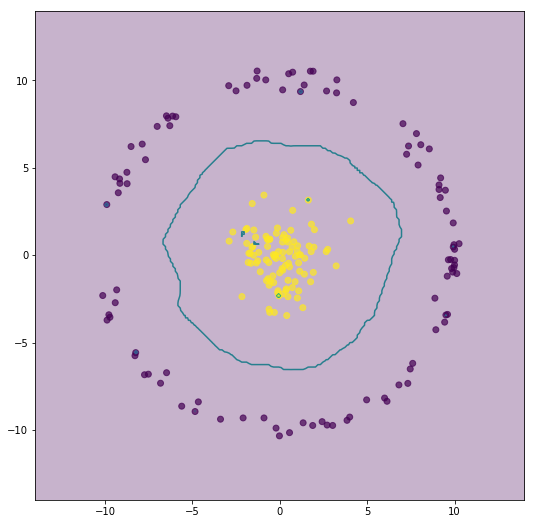

In [277]:
xx,yy = np.meshgrid(np.linspace(-14,14,200),np.linspace(-14,14,200))
viz=np.c_[xx.ravel(),yy.ravel()]

z = test_svm(viz,X,alpha,gamma)

plt.scatter(X[:, 0], X[:, 1], c=col,   alpha=0.7)
plt.gca().set_xlim([-14.,14.])
plt.gca().set_ylim([-14.,14.])
plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-14,14,-14,14),alpha=0.3, vmin=0, vmax=1)
plt.contour(xx,yy,z.reshape((200,200)))

plt.gcf().set_size_inches((9,9))

We can see how all the different methods resulted in a pretty good separation between the two classes. One has to be carefull with the parameters, perhaps even a better line can be created, but a much worse separation is easily implemented. 